In [1]:
import treescope
import torch
from pathlib import Path
from src.model import EvolutionOperator
import linear_operator_learning.nn as lol
treescope.basic_interactive_setup()

In [57]:
run_id = "9r5wpoo9"
data_path = Path(f"/home/novelli/encoderops/encoderops_chignolin/{run_id}")
epoch = 39
model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))

In [58]:
import os
import pickle
data_path = Path(os.environ["CHIG_DATA_PATH"])
trajectory_files = [str(traj) for traj in data_path.glob("*.dcd")]
top = next(data_path.glob("*.pdb")).__str__()
name = next(data_path.glob("*.pdb")).stem
lagtime = model.data_args.lagtime
prepro_data_path = (
    Path().cwd() / f"preprocessed_data/{name}-lag{lagtime}.pkl"
)

# If the file exists then load it with pickle, otherwise call get_dataset and save it
if prepro_data_path.exists():
    with open(prepro_data_path, "rb") as f:
        dataset = pickle.load(f)

KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
from torch_geometric.loader import DataLoader

embeddings = {"t": [], "lag": []}
model = model.eval()

dataloader = DataLoader(
    dataset, batch_size=128, shuffle=False
)
with torch.no_grad():
    for batch in tqdm(dataloader):
        for k, v in batch.items():
            batch[k] = v.to(model.device)
        # data
        x_t = model._setup_graph_data(batch, key="data_list")
        x_lag = model._setup_graph_data(batch, key="data_list_lag")
        # forward
        f_t = model.forward_nn(x_t)
        f_lag = model.forward_nn(x_lag)
        embeddings["t"].append((f_t.detach().cpu()))
        embeddings["lag"].append((f_lag.detach().cpu()))

100%|██████████| 84/84 [00:32<00:00,  2.56it/s]


In [ ]:
phi_t = torch.cat(embeddings["t"])
phi_lag = torch.cat(embeddings["lag"])

In [40]:
cov_X = lol.stats.covariance(phi_t)
cov_Y = lol.stats.covariance(phi_lag)
cov_XY = lol.stats.covariance(phi_lag)
markov_model = lol.ridge_least_squares(cov_X, tikhonov_reg=1e-2)

In [41]:
markov_model

{'U': tensor([[ 2.0025e+00,  0.0000e+00, -1.3696e+00,  ..., -3.6045e-01,
           3.8690e-01,  6.9841e-02],
         [ 2.0008e+00, -7.9341e-04, -1.3687e+00,  ...,  1.9202e-01,
          -7.0499e-01,  9.1605e-02],
         [ 2.0018e+00, -3.4724e-04, -1.3688e+00,  ..., -1.1004e-01,
           2.9031e-01,  3.1423e-02],
         ...,
         [ 1.3508e+00, -8.7780e-01,  1.2343e+00,  ...,  9.4042e-02,
           9.6171e-03,  1.0368e-01],
         [ 1.3505e+00, -8.7691e-01,  1.2343e+00,  ..., -2.1898e-02,
          -1.4461e-02,  1.0528e-01],
         [ 1.3543e+00, -8.7489e-01,  1.2323e+00,  ...,  4.3398e-01,
           1.6063e-01, -1.1917e-01]]),
 'V': tensor([[ 2.0025e+00,  0.0000e+00, -1.3696e+00,  ..., -3.6045e-01,
           3.8690e-01,  6.9841e-02],
         [ 2.0008e+00, -7.9341e-04, -1.3687e+00,  ...,  1.9202e-01,
          -7.0499e-01,  9.1605e-02],
         [ 2.0018e+00, -3.4724e-04, -1.3688e+00,  ..., -1.1004e-01,
           2.9031e-01,  3.1423e-02],
         ...,
         [ 1.3508e+00, -8.7780e-01,  1.2343e+00,  ...,  9.4042e-02,
           9.6171e-03,  1.0368e-01],
         [ 1.3505e+00, -8.7691e-01,  1.2343e+00,  ..., -2.1898e-02,
          -1.4461e-02,  1.0528e-01],
         [ 1.3543e+00, -8.7489e-01,  1.2323e+00,  ...,  4.3398e-01,
           1.6063e-01, -1.1917e-01]]),
 'svals': tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0101, 0.0101,
         0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0101, 0.0102, 0.0102, 0.0102,
         0.0102, 0.0102, 0.0103, 0.0103, 0.0104, 0.0104, 0.0105, 0.0105, 0.0107,
         0.0107, 0.0109, 0.0110, 0.0113, 0.0114, 0.0116, 0.0118, 0.0119, 0.0136,
         0.0146, 0.0157, 0.0190, 0.0249, 0.0292, 0.0476, 0.0577, 0.1653, 0.3309,
         1.4737])}

In [42]:
G_0 = markov_model["U"]@markov_model["U"].T@cov_XY
G_1 = model.linear[0].weight.T.detach().cpu()@model.linear[1].weight.T.detach().cpu() @ cov_Y

In [43]:
G_0

tensor([[ 0.1647, -0.1125, -0.0235,  ..., -0.0231,  0.0504, -0.0283],
        [-0.1126,  0.2515, -0.0682,  ..., -0.0024,  0.0183, -0.0089],
        [-0.0234, -0.0682,  0.1233,  ...,  0.0343, -0.0406, -0.0022],
        ...,
        [-0.0230, -0.0024,  0.0343,  ...,  0.0909, -0.0537, -0.0148],
        [ 0.0506,  0.0182, -0.0405,  ..., -0.0537,  0.1114, -0.0247],
        [-0.0284, -0.0088, -0.0022,  ..., -0.0149, -0.0248,  0.1190]])

In [44]:
G_1

tensor([[ 0.0684, -0.1086,  0.0413,  ..., -0.0076,  0.0030,  0.0082],
        [-0.0556,  0.1110, -0.0361,  ..., -0.0015, -0.0023, -0.0307],
        [ 0.0421, -0.0257,  0.0280,  ...,  0.0280,  0.0223, -0.0273],
        ...,
        [ 0.0050,  0.0195,  0.0020,  ...,  0.0176,  0.0166, -0.0183],
        [-0.0098,  0.0228, -0.0100,  ...,  0.0139,  0.0158,  0.0090],
        [-0.0001, -0.0240,  0.0029,  ..., -0.0164, -0.0166,  0.0214]])

In [45]:
G_0

tensor([[ 0.1647, -0.1125, -0.0235,  ..., -0.0231,  0.0504, -0.0283],
        [-0.1126,  0.2515, -0.0682,  ..., -0.0024,  0.0183, -0.0089],
        [-0.0234, -0.0682,  0.1233,  ...,  0.0343, -0.0406, -0.0022],
        ...,
        [-0.0230, -0.0024,  0.0343,  ...,  0.0909, -0.0537, -0.0148],
        [ 0.0506,  0.0182, -0.0405,  ..., -0.0537,  0.1114, -0.0247],
        [-0.0284, -0.0088, -0.0022,  ..., -0.0149, -0.0248,  0.1190]])

In [46]:
e0 = torch.linalg.eigvals(G_0)
e1 = torch.linalg.eigvals(G_1)

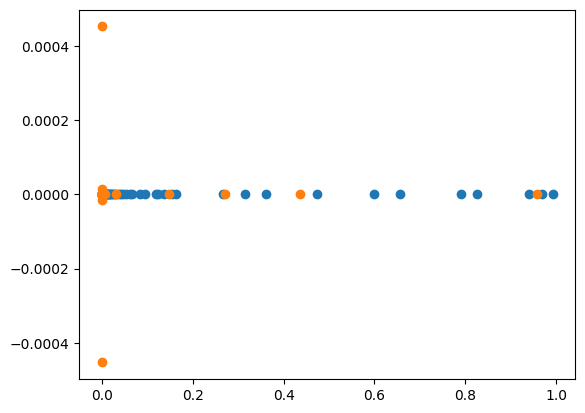

In [47]:
import matplotlib.pyplot as plt
N = phi_t.shape[0]
plt.scatter(e0.real, e0.imag)
plt.scatter(e1.real, e1.imag)

In [48]:
eig_result = lol.eig(markov_model, cov_XY)

In [49]:
e_fun = lol.evaluate_eigenfunction(eig_result, "right", phi_t)

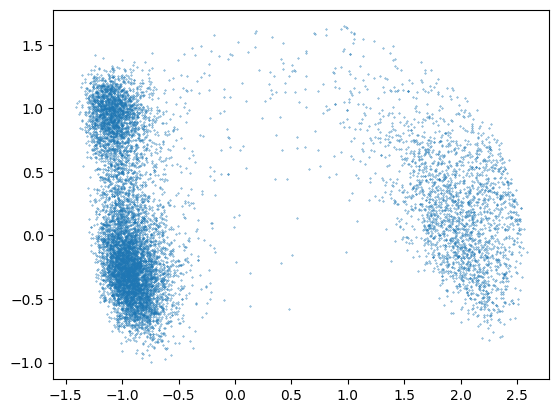

In [55]:
plt.scatter(e_fun[:, -1].real, e_fun[:, -2].real, s=0.1)

In [51]:
print(eig_result['values'])

tensor([-1.2465e-06+0.0000e+00j, -1.0032e-06+0.0000e+00j,
        -6.2911e-07+0.0000e+00j, -5.7660e-07+0.0000e+00j,
        -4.3421e-07-4.8509e-08j, -4.3421e-07+4.8509e-08j,
        -2.6650e-07+0.0000e+00j, -8.1393e-08+0.0000e+00j,
         2.7073e-07-4.2563e-08j,  2.7073e-07+4.2563e-08j,
         5.8590e-07+0.0000e+00j,  7.4161e-07-1.4800e-08j,
         7.4161e-07+1.4800e-08j,  1.1016e-06+0.0000e+00j,
         1.3086e-06+0.0000e+00j,  1.8224e-06+0.0000e+00j,
         8.9853e-04+0.0000e+00j,  9.2477e-04+0.0000e+00j,
         1.5098e-03+0.0000e+00j,  1.7975e-03+0.0000e+00j,
         1.8595e-03+0.0000e+00j,  2.4698e-03+0.0000e+00j,
         2.6105e-03+0.0000e+00j,  4.6146e-03+0.0000e+00j,
         4.8616e-03+0.0000e+00j,  5.6253e-03+0.0000e+00j,
         6.3591e-03+0.0000e+00j,  7.1843e-03+0.0000e+00j,
         7.7142e-03+0.0000e+00j,  9.3485e-03+0.0000e+00j,
         1.0824e-02+0.0000e+00j,  1.1679e-02+0.0000e+00j,
         1.3906e-02+0.0000e+00j,  1.4965e-02+0.0000e+00j,
         1.602